### Notebook to plot histograms from BOWTIE sounding data.

James Ruppert  
jruppert@ou.edu  
11/5/24

### Main settings

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from thermo_functions import *
import subprocess, cmocean
import pandas as pd
import seaborn as sns
from time_series_diag import *
from bowtie_read_data import *

In [2]:
# Soundings
snd_asc, snd_files, times_asc = read_bowtie_soundings(search_string = 'ascen')
# soundings, snd_files, times_snd = read_bowtie_soundings(search_string = 'descen')
hght = snd_asc['hght']

### Compute diagnostics

In [3]:
# Vertical mass-weighted integral
#   inputs:
#       tmpk:   temperature [K]
#       mr:     water vapor mixing ratio [kg/kg]
#       p:      pressure [Pa]
#       hght:   height [m]
#   options:
#       minpres: set this to minimum pressure to integrate over [Pa]
def vert_integral(invar, tmpk, mr, p, hght, minpres=0):
    rho = density_moist(tmpk, mr, p) # kg/m3
    dz = hght[1]-hght[0] # m
    var_int = np.nansum(invar*rho, axis=1, where=(p > minpres))*dz
    var_int[ np.where(var_int == 0) ] = np.nan
    return var_int

# Smooth a variable in the vertical
def smooth_var_z(invar, nz_smooth=10):
    invar_pd = pd.DataFrame(invar)
    # Need to transpose first to put vertical in the first dimension position
    invar_pd = invar_pd.transpose().rolling(window=nz_smooth, center=True, closed='both', min_periods=3).mean()
    # Then un-transpose
    return np.squeeze(np.array(invar_pd.transpose()))

In [4]:
# Constants
cp=1004.  # J/K/kg
cpl=4186. # J/k/kg
cpv=1885. # J/K/kg
lv0=2.5e6 # J/kg
g = 9.81 # m/s2
# Latent heat of vaporization
lv = lv0 - (cpl-cpv)*(snd_asc['tmpk']-273.15)

minpres=50e2 # Upper pressure bound for vertical integrals [Pa]

# MSE
dse = cp*snd_asc['tmpk'] + g*hght[np.newaxis,:]
lvq= lv*snd_asc['mr']
mse = dse + lvq

# Static stability
theta = theta_dry(snd_asc['tmpk'], snd_asc['p'])
for ismooth in range(3):
    theta = smooth_var_z(theta, nz_smooth=10)
dthdz = np.gradient(theta, hght, axis=1) # K/m
# for ido in range(10):
dthdz = smooth_var_z(dthdz, nz_smooth=20)

tmpk_ddz = np.copy(snd_asc['tmpk'])
for ido in range(3):
    tmpk_ddz = smooth_var_z(tmpk_ddz, nz_smooth=10)
dtdz = np.gradient(tmpk_ddz, hght, axis=1) # K/m
dtdz = smooth_var_z(dtdz, nz_smooth=20)

# Relative humidity
rh_asc = calc_relh(snd_asc['mr'], snd_asc['p'], snd_asc['tmpk'], ice=True)

# CWV/PW
# 1/g int(q)dp = s2/m * kg/m/s2 --> kg/m2 --> x1/rho_l --> 10^-3 kg/m2*m3/kg --> 10^-3m = mm
# int<q*rho>dz = kg/m3*m = kg/m2 = mm
cwv = vert_integral(snd_asc['mr'], snd_asc['tmpk'], snd_asc['mr'], snd_asc['p'],
                    hght, minpres=0) # mm or kg/m2

---
### Plotting routines

#### Plot functions

In [5]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 12}

rc('font', **font)

sns.set_theme(style="darkgrid", rc={'xtick.bottom': True, 'ytick.left': True,})

In [38]:
def add_var(figdata, ax, toggle=0):
    ax.set_title(figdata['vartag'])
    ax.set_ylabel('Frequency')
    ax.set_xlabel('Units = '+figdata['units'])
    # if 'count' in figdata:
    #     count = figdata['count']
    # else:
    count=None
    sns.histplot(figdata['pltvar'], ax=ax, kde=True, bins=figdata['bins'], label=count)
    default_colors = sns.color_palette()
    median = np.nanmedian(figdata['pltvar'])
    if toggle == 0:
        linestyle='-.'
    elif toggle == 1:
        linestyle='--'
    elif toggle == 2:
        linestyle=':'
    elif toggle == 3:
        linestyle='-'
    ax.axvline(median, color=default_colors[toggle], linestyle=linestyle, label='Median = '+str(round(median, 2)))
    ax.legend()

#### Variable selection

In [7]:
# Calculate 0-6km shear
nt = times_asc.size
shear06 = np.zeros(nt)
iz1 = np.where(hght == 6e3)[0][0]
iz0=1
for it in range(nt):
    shear06[it] = np.sqrt( (snd_asc['u'][it,iz1] - snd_asc['u'][it,iz0])**2 + (snd_asc['v'][it,iz1] - snd_asc['v'][it,iz0])**2 )

In [33]:
# 0-1-km averaged wind speed
iz1 = np.where(hght == 1e3)[0][0]
iz0 = 0
wspd = np.sqrt(snd_asc['u']**2 + snd_asc['v']**2)
wind_1km = np.nanmean(wspd[:,iz0:iz1+1], axis=1)

/tmp/ipykernel_12998/350486034.py:5: RuntimeWarning: Mean of empty slice
  wind_1km = np.nanmean(wspd[:,iz0:iz1+1], axis=1)


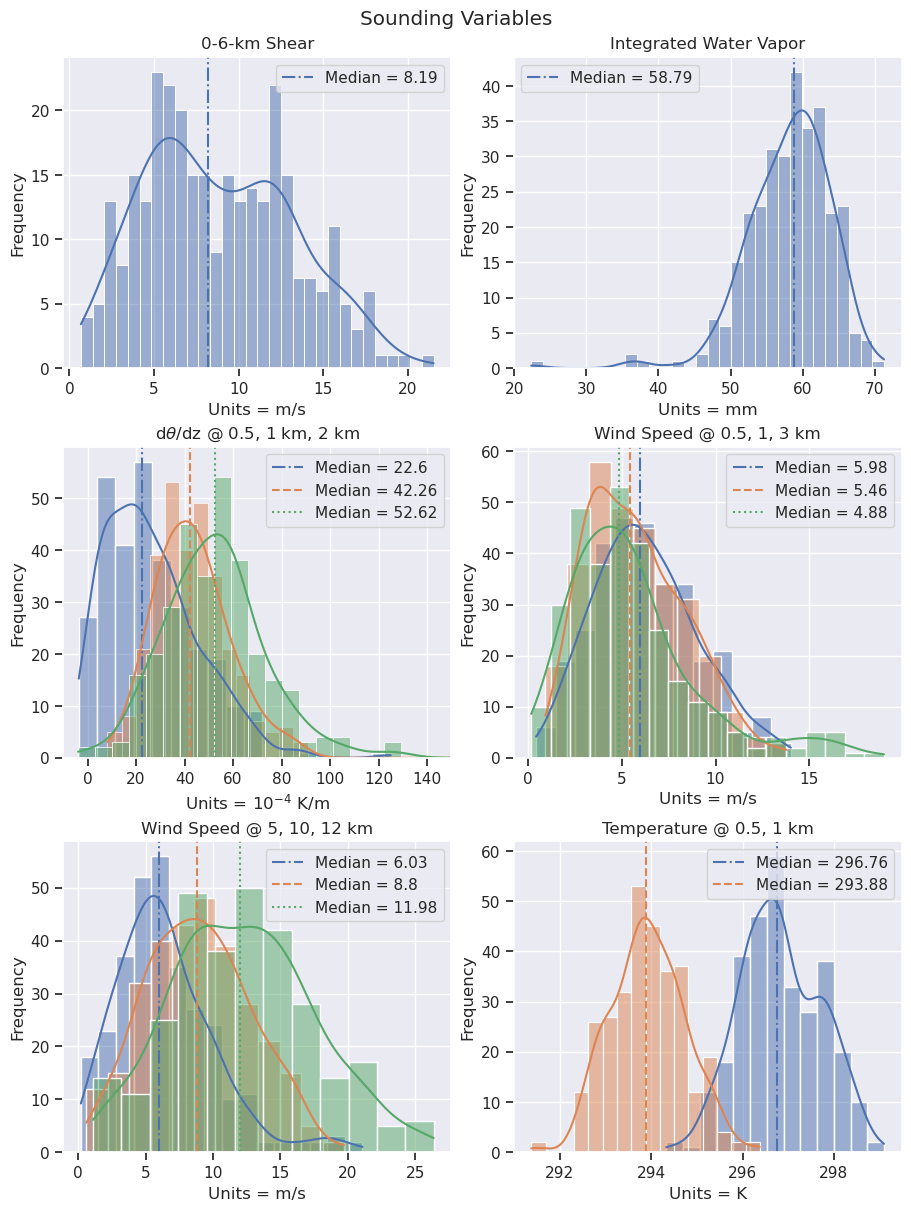

In [47]:
fig_x = 9
fig_y = 12
fig, axs = plt.subplots(3, 2, figsize=(fig_x,fig_y), layout='constrained', squeeze=True)

plt.suptitle('Sounding Variables')

n_soundings = shear06.shape[0]

# for idataset in [df, subset]:
# for itoggle in range(2):
# for itoggle in range(1):

itoggle = 0

# if itoggle == 0:
#     idataset = df
# else:
#     idataset = subset

figdata = {
    'pltvar': shear06,
    'vartag': '0-6-km Shear',
    'units': 'm/s',
    'bins': 30,
    'count': n_soundings,
        }
add_var(figdata, axs[0,0], toggle=itoggle)

################################

figdata = {
    'pltvar': cwv,
    'vartag': 'Integrated Water Vapor',
    'units': 'mm',
    'bins': 30,
        }
add_var(figdata, axs[0,1], toggle=itoggle)

################################

figdata = {
    'pltvar': dthdz[:,50]*1e4,
    'vartag': 'd$\\theta$/dz @ 0.5, 1 km',
    'units': '10$^{-4}$ K/m',
    'bins': 'auto',
        }
add_var(figdata, axs[1,0], toggle=itoggle)
figdata = {
    'pltvar': dthdz[:,100]*1e4,
    'vartag': 'd$\\theta$/dz @ 0.5, 1 km',
    'units': '10$^{-4}$ K/m',
    'bins': 'auto',
        }
add_var(figdata, axs[1,0], toggle=1)
figdata = {
    'pltvar': dthdz[:,200]*1e4,
    'vartag': 'd$\\theta$/dz @ 0.5, 1 km, 2 km',
    'units': '10$^{-4}$ K/m',
    'bins': 'auto',
        }
add_var(figdata, axs[1,0], toggle=2)
axs[1,0].set_xlim(-10, 150)

################################

# figdata = {
#     'pltvar': wind_1km,
#     'vartag': 'Wind Speed (0-1-km mean)',
#     'units': 'm/s',
#     'bins': 'auto',
#         }
# add_var(figdata, axs[1,1], toggle=itoggle)
figdata = {
    'pltvar': wspd[:,50],
    'vartag': 'Wind Speed @ 0.5, 1, 3 km',
    'units': 'm/s',
    'bins': 'auto',
        }
add_var(figdata, axs[1,1], toggle=0)
figdata = {
    'pltvar': wspd[:,100],
    'vartag': figdata['vartag'],
    'units': 'm/s',
    'bins': 'auto',
        }
add_var(figdata, axs[1,1], toggle=1)
figdata = {
    'pltvar': wspd[:,300],
    'vartag': figdata['vartag'],
    'units': 'm/s',
    'bins': 'auto',
        }
add_var(figdata, axs[1,1], toggle=2)

# ################################

figdata = {
    'pltvar': wspd[:,500],
    'vartag': 'Wind Speed @ 5, 10, 12 km',
    'units': 'm/s',
    'bins': 'auto',
        }
add_var(figdata, axs[2,0], toggle=itoggle)
figdata = {
    'pltvar': wspd[:,1000],
    'vartag': figdata['vartag'],
    'units': 'm/s',
    'bins': 'auto',
        }
add_var(figdata, axs[2,0], toggle=1)
figdata = {
    'pltvar': wspd[:,1200],
    'vartag': figdata['vartag'],
    'units': 'm/s',
    'bins': 'auto',
        }
add_var(figdata, axs[2,0], toggle=2)

# ################################

figdata = {
    'pltvar': snd_asc['tmpk'][:,50],
    'vartag': 'Temperature @ 0.5, 1 km',
    'units': 'K',
    'bins': 'auto',
        }
add_var(figdata, axs[2,1], toggle=itoggle)
figdata = {
    'pltvar': snd_asc['tmpk'][:,100],
    'vartag': figdata['vartag'],
    'units': 'K',
    'bins': 'auto',
        }
add_var(figdata, axs[2,1], toggle=1)

# axs[0,1].legend()#loc='upper right')
plt.show()
plt.close()